Importing Libraries and Dependancies

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

import shutup
shutup.please()

Custom Model Training Function

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

def train_evaluate_model(model, X, y, n_splits=5, is_nn=False, epochs=100):
    '''
    arguments:
        model -- A scikit-learn estimator instance for regression
        X -- The input features for the model
        y -- The target variable for the model
        n_splits -- The number of folds to use in the KFold cross-validation (default=5)

    Returns:
        a dictionary of evaluation metrics for the model
    '''
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store the evaluation metrics
    mse_scores = []
    r2_scores = []
    adj_r2_scores = []
    rmse_scores = []

    # Use k-fold cross-validation to evaluate the model
    for train_index, test_index in kf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # Fit the model to the training data
        if is_nn:
            model.fit(X_train, y_train, epochs=epochs, verbose=0)
        else:
            model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Compute the evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        rmse = np.sqrt(mse)

        # Append the scores to the lists
        mse_scores.append(mse)
        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)
        rmse_scores.append(rmse)

    # Compute the mean and standard deviation of the evaluation metrics
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    r2_mean = np.mean(r2_scores)
    r2_std = np.std(r2_scores)
    adj_r2_mean = np.mean(adj_r2_scores)
    adj_r2_std = np.std(adj_r2_scores)
    rmse_mean = np.mean(rmse_scores)
    rmse_std = np.std(rmse_scores)

    # Create a dataframe to store the evaluation metrics
    eval_df = pd.DataFrame({
        'RMSE': [rmse_mean],
        'RMSE_StdDev': [rmse_std],
        'Mean_Squared_Error': [mse_mean], 
        'MSE_StdDev': [mse_std], 
        'R_squared': [r2_mean], 
        'R2_StdDev': [r2_std],
        'Adjusted_R_squared': [adj_r2_mean],
        'Adj_R2_StdDev': [adj_r2_std],

    })

    return eval_df


Loading the Data

In [3]:
with open('soybean.pkl', 'rb') as pickle_file:
    soybean = pickle.load(pickle_file)

Basic Descriptive Stats

In [37]:
soybean.describe()

,Year,max_humidity 1,max_humidity 2,max_humidity 3,max_humidity 4,max_humidity 5,max_humidity 6,max_humidity 7,max_humidity 8,max_humidity 9,...,wind_speed 44,wind_speed 45,wind_speed 46,wind_speed 47,wind_speed 48,wind_speed 49,wind_speed 50,wind_speed 51,wind_speed 52,Soybean_Yield
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,...,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,2000.000000,90.128976,88.461592,89.376816,89.003377,88.387644,89.119325,88.682793,89.050415,87.544867,...,4.571134,4.616671,4.599437,4.654248,4.629268,4.485875,4.307880,4.473546,4.509176,38.860225
std,11.843275,7.827949,8.241539,7.471159,7.889270,8.751590,9.262400,8.259970,8.020290,8.431716,...,0.909055,0.906491,0.953358,0.996747,0.865097,0.952732,0.873012,0.981876,1.020454,8.912570
min,1980.000000,63.942857,59.614286,62.714286,52.557143,60.700000,49.800000,51.971429,58.800000,62.014286,...,2.400000,2.557143,2.014286,2.014286,2.442857,2.142857,2.214286,2.100000,1.971429,16.000000
25%,1990.000000,85.825000,82.942857,83.985714,84.271429,83.228571,84.557143,84.142857,84.071429,81.657143,...,3.928571,4.000000,3.928571,4.000000,4.000000,3.885714,3.657143,3.800000,3.787500,32.500000
50%,2000.000000,92.150000,89.542857,90.700000,90.114286,90.157143,91.128571,90.214286,90.800000,88.657143,...,4.542857,4.542857,4.542857,4.628571,4.585714,4.371429,4.271429,4.400000,4.425000,38.000000
75%,2010.000000,95.900000,95.200000,95.357143,95.471429,95.314286,96.142857,94.714286,95.171429,94.271429,...,5.142857,5.214286,5.228571,5.257143,5.271429,4.985714,4.871429,5.042857,5.137500,45.000000
max,2020.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,8.285714,8.071429,8.300000,8.300000,7.385714,8.557143,7.971429,8.328571,8.166667,63.500000


In [38]:
soybean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 532
Columns: 471 entries, Year to Soybean_Yield
dtypes: float64(469), int64(1), object(1)
memory usage: 1.9+ MB


Dropping week 53 (the only columns with null values)

In [4]:
soybean = soybean.dropna(axis=1)

Checking Shape

In [5]:
print(f'Shape of soybean dataframe',soybean.shape)

Shape of soybean dataframe (533, 471)


Dropping weather variables from week 1-21

In [6]:
variables = ['min_humidity', 'max_humidity', 'min_temp', 'max_temp', 'vapor_pressure_deficit', 
             'near_surface_specific_humidity', 'precipitation', 'solar_radiation', 'wind_speed']

columns_to_drop = []

for var in variables:
    columns_to_drop.extend(['{} {}'.format(var, i) for i in range(1, 22)])

# Drop the columns from the dataframe
df_soy = soybean.drop(columns = columns_to_drop)


Defining X and y

In [7]:
X_soy = df_soy.drop(['Year', 'state', 'Soybean_Yield'], axis=1)

In [8]:
X_soy.head()

,max_humidity 22,max_humidity 23,max_humidity 24,max_humidity 25,max_humidity 26,max_humidity 27,max_humidity 28,max_humidity 29,max_humidity 30,max_humidity 31,...,wind_speed 43,wind_speed 44,wind_speed 45,wind_speed 46,wind_speed 47,wind_speed 48,wind_speed 49,wind_speed 50,wind_speed 51,wind_speed 52
0,88.942857,93.157143,88.985714,79.757143,86.900000,92.957143,92.800000,91.671429,95.242857,91.800000,...,5.057143,4.085714,5.442857,4.000000,4.600000,4.785714,4.242857,3.671429,3.885714,4.271429
1,87.571429,96.957143,87.871429,87.328571,91.971429,94.485714,94.671429,93.814286,96.142857,97.057143,...,4.971429,3.600000,5.342857,3.714286,4.200000,4.871429,4.242857,3.828571,3.642857,3.657143
2,96.771429,92.642857,86.957143,90.314286,90.328571,94.614286,97.142857,95.085714,99.485714,92.085714,...,4.728571,4.057143,4.600000,3.671429,4.585714,4.085714,4.071429,3.528571,3.857143,4.657143
3,95.414286,97.371429,76.857143,94.357143,87.271429,84.571429,69.542857,67.371429,93.157143,61.814286,...,4.771429,4.314286,4.242857,5.428571,4.800000,4.128571,5.314286,3.857143,4.785714,5.128571
4,90.414286,91.342857,84.357143,90.128571,90.871429,96.814286,96.471429,90.200000,96.485714,96.857143,...,4.114286,3.242857,4.657143,3.742857,3.057143,5.114286,3.671429,3.657143,3.757143,3.514286


In [9]:
y_soybean = soybean['Soybean_Yield']


In [10]:
y_soybean.head(20)

0     33.5
1     36.0
2     38.5
3     16.5
4     22.5
5     33.0
6     31.5
7     24.5
8     30.0
9     17.5
10    36.0
11    26.0
12    33.0
13    38.0
14    33.0
15    40.0
16    30.0
17    29.0
18    30.0
19    32.0
Name: Soybean_Yield, dtype: float64

Modelling

In [11]:
lr = LinearRegression()
results = train_evaluate_model(lr, X_soy, y_soybean, 3)
results.index = ['LinearRegression']

results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [13]:
decision_tree = DecisionTreeRegressor()
decision_tree_results = train_evaluate_model(decision_tree, X_soy, y_soybean, 3)

decision_tree_results.index = ['DecisionTree']
# results = pd.concat([results, decision_tree_results], ignore_index=False)

results = results.append(decision_tree_results)

In [14]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
 

,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [15]:
xgboost = xgb.XGBRegressor()
xgboost_result = train_evaluate_model(xgboost, X_soy, y_soybean, 3)
xgboost_result.index = ['XGBoost']

results = results.append(xgboost_result)

In [16]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [17]:
lgbmr = LGBMRegressor()
lgbmr_result = train_evaluate_model(lgbmr, X_soy, y_soybean, 3)
lgbmr_result.index = ['LGBM']

results = results.append(lgbmr_result)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31608
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 279
[LightGBM] [Info] Start training from score 39.090141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [18]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [19]:
from sklearn.ensemble import AdaBoostRegressor
ada_regressor = AdaBoostRegressor()
ada_result = train_evaluate_model(ada_regressor, X_soy, y_soybean, 3)
ada_result.index = ['AdaBoost']
results = results.append(ada_result)

In [20]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
AdaBoost,6.643508,0.420693,44.313176,5.714584,0.440716,0.057208,1.966062,0.103696
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [21]:
catboost = CatBoostRegressor(verbose=False)
catboost_result = train_evaluate_model(catboost, X_soy, y_soybean, 3)
catboost_result.index = ['Catboost']

results = results.append(catboost_result)

In [22]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
Catboost,5.799565,0.416770,33.808651,4.956916,0.573544,0.050568,1.736650,0.090833
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
AdaBoost,6.643508,0.420693,44.313176,5.714584,0.440716,0.057208,1.966062,0.103696
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [23]:
rfr= RandomForestRegressor()
rfr_result = train_evaluate_model(rfr, X_soy, y_soybean, 3)
rfr_result.index = ['RandomForest']

results = results.append(rfr_result)

In [24]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
Catboost,5.799565,0.416770,33.808651,4.956916,0.573544,0.050568,1.736650,0.090833
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
RandomForest,6.527088,0.424895,42.783409,5.674177,0.460136,0.056647,1.932501,0.102345
AdaBoost,6.643508,0.420693,44.313176,5.714584,0.440716,0.057208,1.966062,0.103696
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [25]:
regressors = [('lgbmr', LGBMRegressor()),('catboost', CatBoostRegressor(verbose=False)), ('xgb', xgb.XGBRegressor())]
voting_regressor = VotingRegressor(regressors)
voting_regressor_result = train_evaluate_model(voting_regressor, X_soy, y_soybean, 3)
voting_regressor_result.index = ['Ensemble']

results = results.append(voting_regressor_result)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31608
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 279
[LightGBM] [Info] Start training from score 39.090141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [26]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
Catboost,5.799565,0.416770,33.808651,4.956916,0.573544,0.050568,1.736650,0.090833
Ensemble,5.999322,0.380424,36.136589,4.660902,0.543791,0.047731,1.788072,0.086740
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
RandomForest,6.527088,0.424895,42.783409,5.674177,0.460136,0.056647,1.932501,0.102345
AdaBoost,6.643508,0.420693,44.313176,5.714584,0.440716,0.057208,1.966062,0.103696
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Create and train the Gradient Boosting Regressor
gboost = GradientBoostingRegressor()
gboost_result = train_evaluate_model(gboost, X_soy, y_soybean, 3)
gboost_result.index = ['GradientBoostings']

# Append the results
results = results.append(gboost_result)


In [28]:
results.sort_values(by='RMSE',ascending=True).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))


,RMSE,RMSE_StdDev,Mean_Squared_Error,MSE_StdDev,R_squared,R2_StdDev,Adjusted_R_squared,Adj_R2_StdDev
Catboost,5.799565,0.416770,33.808651,4.956916,0.573544,0.050568,1.736650,0.090833
Ensemble,5.999322,0.380424,36.136589,4.660902,0.543791,0.047731,1.788072,0.086740
LGBM,6.030651,0.169878,36.397615,2.046089,0.539319,0.025633,1.795654,0.049729
GradientBoostings,6.162124,0.301243,38.062517,3.754446,0.518901,0.039238,1.831040,0.073059
RandomForest,6.527088,0.424895,42.783409,5.674177,0.460136,0.056647,1.932501,0.102345
AdaBoost,6.643508,0.420693,44.313176,5.714584,0.440716,0.057208,1.966062,0.103696
XGBoost,6.796471,0.554763,46.499776,7.739858,0.413451,0.082859,2.013405,0.148447
DecisionTree,9.898451,0.408550,98.146245,8.172337,-0.243296,0.113443,3.145328,0.183200
LinearRegression,10.218517,0.470264,104.639245,9.747068,-0.322372,0.096188,3.284044,0.180158


Feature Importance

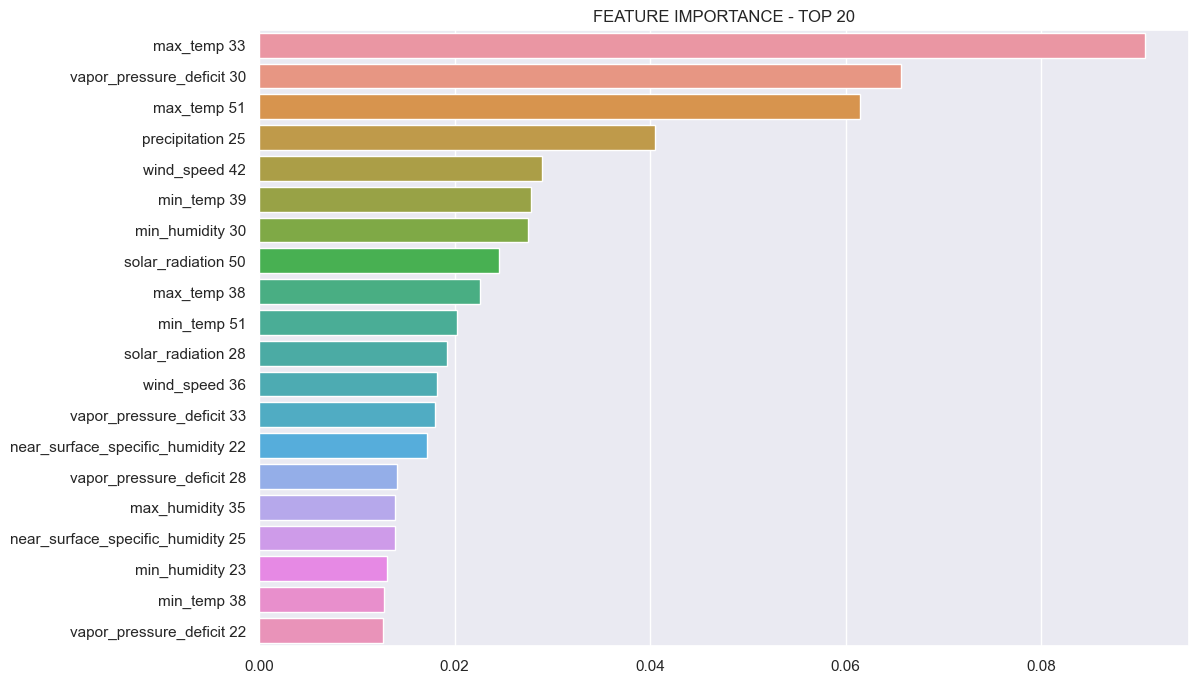

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming xgboost is your trained model and X_corn is your feature dataframe
importances = xgboost.feature_importances_
features = X_soy.columns

# Sort the features based on importance
sorted_idx = importances.argsort()[-20:][::-1]
sorted = importances.argsort()[-100:][::-1]
top_50 = features[sorted]
top_importances = importances[sorted_idx]
top_features = features[sorted_idx]

# Plotting
sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_palette('colorblind')
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=top_importances, y=top_features)
plt.title('FEATURE IMPORTANCE - TOP 20')
plt.show()

Model Comparision

In [30]:
models = results.T.columns.values

Mean Squared Error

In [31]:
fig = px.bar(
    x=results.iloc[:9, 0].values,
    y=models,
    orientation='h',
    color=results['Mean_Squared_Error'].iloc[:9],
    color_continuous_scale='rdpu_r',  
    template="seaborn"
)

fig.update_layout(width=800, height=600,
                 xaxis=dict(title='Mean_Squared_Error'),
                 yaxis=dict(title="Models"))

fig.show()

R2

In [32]:

fig = px.bar(
    x=results.iloc[:9, 2].values,
    y=models,
    orientation='h',
    color=results['R_squared'].iloc[:9],
    color_continuous_scale='rdpu',  
    template="seaborn"
)

fig.update_layout(width=800, height=600,
                 xaxis=dict(title='R_squared'),
                 yaxis=dict(title="Models"))

fig.show()

RMSE

In [33]:

fig = px.bar(
    x=results.iloc[:9, 2].values,
    y=models,
    orientation='h',
    color=results['RMSE'].iloc[:9],
    color_continuous_scale='rdpu',  
    template="seaborn"
)

fig.update_layout(width=800, height=600,
                 xaxis=dict(title='RMSE'),
                 yaxis=dict(title="Models"))

fig.show()

Adjusted R2

In [34]:

fig = px.bar(
    x=results.iloc[:9, 2].values,
    y=models,
    orientation='h',
    color=results['Adjusted_R_squared'].iloc[:9],
    color_continuous_scale='rdpu',  
    template="seaborn"
)

fig.update_layout(width=800, height=600,
                 xaxis=dict(title='Adjusted_R_squared'),
                 yaxis=dict(title="Models"))

fig.show()

Hyperparameter Tuning & Saving Best Model

In [35]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# import joblib  # For saving the best model

# # Define a dictionary with model classes and their respective parameter grids
# model_param_grid = {
#     'CatBoostRegressor': {
#         'model': CatBoostRegressor(),
#         'params': {
#             'depth': [4, 6],
#             'learning_rate': [0.01, 0.1]
#             # 'iterations': [100, 200, 500]
#         }}
#     # },
#     # 'XGBRegressor': {
#     #     'model': XGBRegressor(),
#     #     'params': {
#     #         'max_depth': [3, 5, 7],
#     #         'learning_rate': [0.01, 0.1, 0.2],
#     #         'n_estimators': [100, 200, 300],
#     #         'min_child_weight': [1, 3, 5]
#     #     }
#     # },
#     # 'GradientBoostingRegressor': {
#     #     'model': GradientBoostingRegressor(),
#     #     'params': {
#     #         'n_estimators': [100, 200, 300],
#     #         'learning_rate': [0.01, 0.1, 0.2],
#     #         'max_depth': [3, 5, 7]
#     #     }
#     # },
#     # 'LGBMRegressor': {
#     #     'model': LGBMRegressor(),
#     #     'params': {
#     #         'num_leaves': [31, 62, 127],
#     #         'learning_rate': [0.01, 0.1, 0.2],
#     #         'n_estimators': [100, 200, 300]
#     #     }
#     # },
#     # 'RandomForestRegressor': {
#     #     'model': RandomForestRegressor(),
#     #     'params': {
#     #         'n_estimators': [100, 200, 300],
#     #         'max_depth': [None, 10, 20]
#     #     }
#     # }
# }

# def perform_hyperparameter_tuning(X, y, model_param_grid, cv=5, n_iter=10, search_type='grid'):
#     best_models = {}
#     for model_name, model_info in model_param_grid.items():
#         print(f"Tuning hyperparameters for {model_name}...")
        
#         if search_type == 'grid':
#             search = GridSearchCV(model_info['model'], model_info['params'], cv=cv, n_jobs=-1, verbose=1)
#         elif search_type == 'random':
#             search = RandomizedSearchCV(model_info['model'], model_info['params'], cv=cv, n_iter=n_iter, n_jobs=-1, verbose=1, random_state=42)
#         else:
#             raise ValueError("search_type must be 'grid' or 'random'")
        
#         search.fit(X, y)
        
#         best_models[model_name] = search.best_estimator_
#         print(f"Best parameters for {model_name}: {search.best_params_}")

#         # Save the best model
#         joblib.dump(search.best_estimator_, f"{model_name}Soy_best_model.joblib")
#         print(f"Saved the best model for {model_name} as {model_name}Soy_best_model.joblib")
    
#     return best_models


In [36]:
# soy_model = perform_hyperparameter_tuning(X_soy_scaled, y_soybean, model_param_grid, cv=5, n_iter=10, search_type='grid')